<a href="https://colab.research.google.com/github/VSurzhan/DL/blob/main/%D0%A1%D1%83%D1%80%D0%B6%D0%B0%D0%BD_HW05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание №5

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

В этом домашнем задании вам предстоит обучить нейросеть на задачу предсказания героев сериала "Симпсоны".

Вам будет дан тренировочный и тестовый наборы данных. Вам нужно будет обучить нейросеть на тренировочных данных и получить предсказания на тестовых данных. Эти предсказания нужно будет отправить на Я.Контест. Ваш балл за задание — значение метрики accuracy между предсказаниями вашей модели и правильными ответами на тестовый набор картинок.

Ниже дан код скачивания и загрузки данных, с которыми вы будете работать.

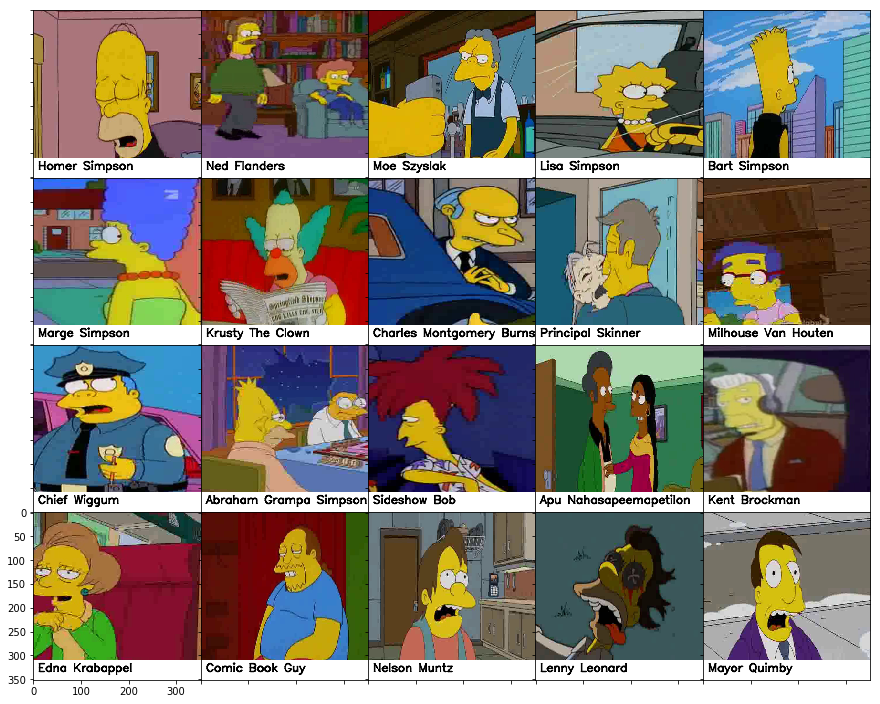

## Загрузка данных

Две ячейки ниже скачивают архив с данными и распаковывают этот архив. Не нужно менять эту ячейку.

In [ ]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.com/d/Ggl9017wNIN0vg) -o simpsons.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  529M  100  529M    0     0  35.3M      0  0:00:15  0:00:15 --:--:-- 38.4M


***Замечание!*** Яндекс. Диск накладывает некоторые ограничения на число одновременных скачиваний в день по ссылкам. Поэтому, код в ячейке выше может выдавать ошибку. В этом случае необходимо будет раскомментировать и запустить код из ячейки ниже (в ней данные скачиваются по альтернативной ссылке):

In [ ]:
#! pip install wldhx.yadisk-direct
#! curl -L $(yadisk-direct https://disk.yandex.ru/d/MweozIqon2ybsQ) -o simpsons.zip

Далее разархивируем скачанный архив. Не нужно менять эту ячейку:

In [ ]:
! unzip -qq simpsons.zip

Импортируем нужные библиотеки:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

Зададим преобразования, которые будут совершаться c изображениями перед подачей в нейросеть. Вы можете изменять эти преобразования по своему желанию.

Обратите внимание, что если вы собираетесь использовать предобученную нейросеть (vgg, resnet, ...), то преобразования должны быть теми же, что использовались при предобучении этой нейросети. Какие преобразования используются для той или иной сети и как использовать их в коде, можно найти в [документации pytorch](https://pytorch.org/vision/stable/models.html).

Если же вы будете обучать свою собственную нейросеть с нуля, вы можете выбирать преобразования по своему усмотрению.

In [ ]:
resnet_transforms = transforms.Compose([
        transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
        transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

# преобразования для конкретной предобученной сети проще получить вот так
# resnet_transforms = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

Создадим датасеты из данных. Обратите внимание, что для тестовых данных вам не известны ответы: внутри папки `./simpsons_data/test` нет подпапок с названиями классов, там всего одна папка со всеми изображениями. Ваша задача — обучить нейросеть, используя тренировочные данные, для которых вам известны ответы, получить с помощью обученной нейросети предсказания для тестовых данных и сдать их в качестве ответа.

In [ ]:
train_data = datasets.ImageFolder('./simpsons_data/train', transform=resnet_transforms)
test_data = datasets.ImageFolder('./simpsons_data/test', transform=resnet_transforms)

Получим соответствие номеров классов и их названий:

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22,
 'martin_prince': 23,
 'mayor_quimby': 24,
 'milhouse_van_houten': 25,
 'miss_hoover': 26,
 'moe_szyslak': 27,
 'ned_flanders': 28,
 'nelson_muntz': 29,
 'otto_mann': 30,
 'patty_bouvier': 31,
 'principal_skinner': 32,
 'professor_john_frink': 33,
 'rainier_wolfcastle': 34,
 'ralph_wiggum': 35,
 'selma_bouvier': 36,
 'sideshow_bob': 37,
 'sideshow_mel': 38,
 'snake_jailbird': 39,
 'troy_mcclure': 40,
 'waylon_smithers': 41}

Разделим тренировочную выборку на две части: тренировочную и валидационную. На тренировочной части, как обычно, будем обучать нейросеть, а на валидационной будем сеть тестировать.

In [ ]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

Создадим три даталоадера для трех частей данных:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

И посмотрим на несколько картинок из обучающей выборки, чтобы понимать, с чем мы имеем дело.

In [ ]:
for batch in test_loader:
    # батч картинок и батч ответов к картинкам
    images, labels = batch
    break

In [ ]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))

    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы)
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

Отрисуем картинки. Картинки будут отрисованы уже после преобразований (transforms), поэтому они могут быть не очень естественных цветов, если среди преобразований была нормализация. Не пугайтесь =)

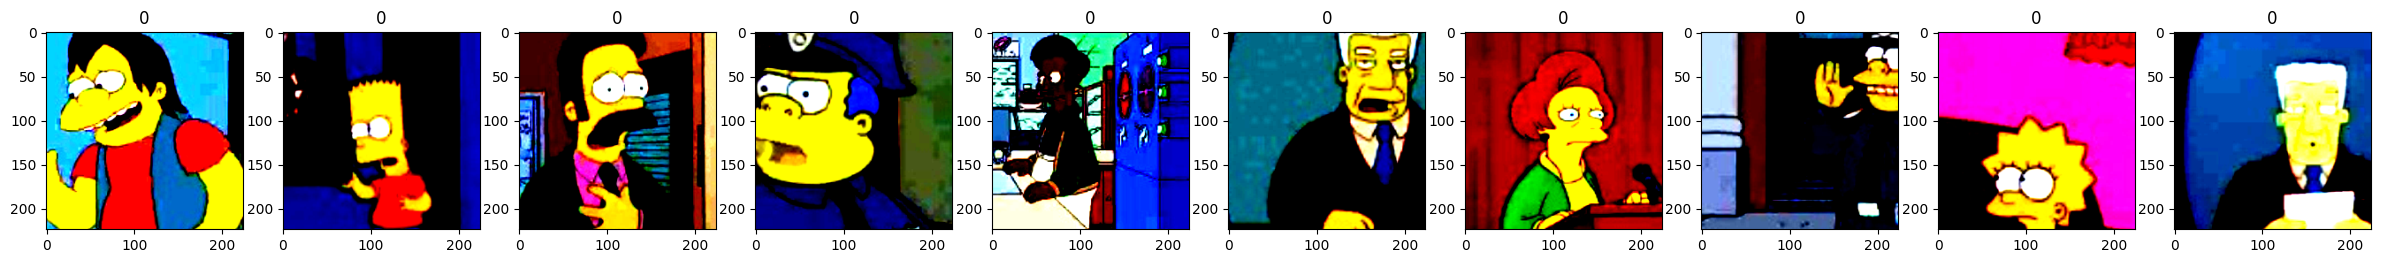

In [ ]:
show_images(images, labels)

## Построение и обучение модели

Ваша задача — обучить нейросеть на тренировочных и валидационных данных, и получить предсказания на тестовых данных. Эти предсказания нужно будет отправить в качестве решения на Я.Контест. Ваш итоговый балл будет определяться как значение метрики accuracy, посчитанное между правильными ответами на картинки тестовой выборки, и ответами вашей модели, которые вы отправили в систему.

Для построения и обучения нейросети можно и нужно пользоваться материалами с прошлых семинаров и домашних заданий.

Идеи, как получить больший скор:
- попробуйте обучить свою нейросеть с нуля, как мы это делали на четвертом занятии и в четвертом домашнем задании. Попробуйте варьировать архитектуру сети и различные гиперпараметры (количество слоев, фильтров в слоях и т.п.), чтобы получить лучший скор на валидации;
- попробуйте взять предобученную нейросеть (resnet-18, к примеру), и дообучить ее на наших данных, как мы это делали на пятом занятии. Обратите внимание на преобразования (transforms): они должны соответствовать той архитектуре, которую вы дообучаете. Попробуйте замораживать разное количество слоев, посмотрите, как это влияет на результат.
- попробуйте применить аугментацию данных для тренировочной выборки. Про аугментацию данных [можно почитать на Хабре](https://habr.com/ru/company/smartengines/blog/264677/). Примеры аугментации в pytorch [можно найти в документации](https://pytorch.org/vision/stable/transforms.html).
Обратите внимание, что аугментация должна применяться только к обучающей (train) выборке. К валидационной и тестовой выборкам она применяться не должна. Поэтому вам нужно будет создать два разных пайплайна transforms: один для тренировочной части, один для валидационной и тестовой частей.

В процессе обучения сети обращайте внимание на скор на валидации. Значение метрики на валидации — это ориентир, который позволяет понять, как примерно будет вести себя ваша сеть на тестовой выборке. Но обратите внимание, что результат на тестовой и валидационной выборке может отличаться.

У вас 100 попыток сдачи решения в Я.Контест: это очень много. Но мы просим вас подойти к заданию осознанно. Пожалуйста, не перебирайте ответы бездумно и не посылайте в качестве ответа все подряд. Старайтесь получить хорошую нейросеть перед тем как отправлять ее ответы на Я.Контест.

----------------

Проверяем, доступен ли GPU (если не доступен, включите GPU в настройках ноутбука):

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F
# метрика качества
from sklearn.metrics import accuracy_score
# импортируем BatchNorm
from torch.nn.modules.batchnorm import BatchNorm1d
from torch.nn.modules.batchnorm import BatchNorm2d

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        # размер исходной картинки 224х224

        # conv 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3)) #222x222
        # conv_batch 1
        self.cb1 = nn.BatchNorm2d(64)
        # pool1
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) #111x111

        # conv 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4,4)) #108x108
        # conv_batch 2
        self.cb2 = nn.BatchNorm2d(64)
        # pool 2
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2)) #54x54

        # conv 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)) #52x52
        # conv_batch 3
        self.cb3 = nn.BatchNorm2d(128)
        # pool 3
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2)) #26x26

        # conv 4
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3)) #24x24
        # conv_batch 4
        self.cb4 = nn.BatchNorm2d(128)
        # pool 4
        self.pool4 = nn.MaxPool2d(kernel_size=(2,2)) #12x12

        # conv 5
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3)) #10x10
        # conv_batch 5
        self.cb5 = nn.BatchNorm2d(256)
        # pool 5
        self.pool5 = nn.MaxPool2d(kernel_size=(2,2)) #5x5

        # conv 6
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3)) #3x3
        # conv_batch 6
        self.cb6 = nn.BatchNorm2d(256)
        # pool 6
        self.pool6 = nn.MaxPool2d(kernel_size=(3,3)) #1x1


        # flatten
        self.flatten = nn.Flatten()

        # linear 1
        self.fc1 = nn.Linear(256, 128)
        # batch 1
        self.bn1 = BatchNorm1d(128)
        # linear 2
        self.fc2 = nn.Linear(128, 64)
        # batch 2
        self.bn2 = BatchNorm1d(64)
        # linear 3
        self.fc3 = nn.Linear(256, 42, bias = True)


    def forward(self, x):
        # размерность х ~ [448, 3, 224, 224]

        x = F.relu(self.conv1(x))
        x = self.cb1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.cb2(x)
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.cb3(x)
        x = self.pool3(x)

        x = F.relu(self.conv4(x))
        x = self.cb4(x)
        x = self.pool4(x)

        x = F.relu(self.conv5(x))
        x = self.cb5(x)
        x = self.pool5(x)

        x = F.relu(self.conv6(x))
        x = self.cb6(x)
        x = self.pool6(x)

        x = self.flatten(x)

        #x = F.relu(self.fc1(x))
        #x = self.bn1(x)
        #x = F.relu(self.fc2(x))
        #x = self.bn2(x)
        x = self.fc3(x)

        return x

In [ ]:
def evaluate(model, dataloader, loss_fn):

    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, y_batch = batch
        num_elements += len(y_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))

            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            y_pred = torch.argmax(logits, dim=1)

            num_correct += torch.sum(y_pred.cpu() == y_batch)

    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

In [ ]:
def train(model, loss_fn, optimizer, n_epoch=3):

    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch+1)

        model.train(True)

        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            X_batch, y_batch = batch

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))
            running_losses.append(loss.item())

            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            # вычислим accuracy на текущем train батче
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)

            # Логирование результатов
            if (i+1) % 100 == 0:
                print("Средние train лосс и accuracy на последних 50 итерациях:",
                      np.mean(running_losses), np.mean(running_accuracies), end='\n')

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        print("Эпоха {}/{}: val лосс и accuracy:".format(epoch+1, n_epoch,),
                      val_loss, val_accuracy, end='\n')

    return model

In [ ]:
# снова объявим модель
model = ConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, loss_fn, optimizer, n_epoch=3)

Epoch: 1
Средние train лосс и accuracy на последних 50 итерациях: 3.71563392162323 0.08765625
Средние train лосс и accuracy на последних 50 итерациях: 3.2885553216934205 0.18140624
Эпоха 1/3: val лосс и accuracy: 2.4289667967594033 0.39216623
Epoch: 2
Средние train лосс и accuracy на последних 50 итерациях: 2.266234065294266 0.43578124
Средние train лосс и accuracy на последних 50 итерациях: 2.185673524737358 0.45117188
Эпоха 2/3: val лосс и accuracy: 1.980281533616962 0.49892524
Epoch: 3
Средние train лосс и accuracy на последних 50 итерациях: 1.8567985928058623 0.53078127
Средние train лосс и accuracy на последних 50 итерациях: 1.7792566072940827 0.5548437
Эпоха 3/3: val лосс и accuracy: 1.7325517481023616 0.5581562


In [ ]:
test_accuracy, _ = evaluate(model, test_loader, loss_fn)
print('Accuracy на тесте', test_accuracy)

Accuracy на тесте 0.030272452


In [ ]:
# модель resnet-18
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [ ]:
resnet_transforms = transforms.Compose([
        transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
        transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, loss_fn, optimizer, n_epoch=3)

Epoch: 1
Средние train лосс и accuracy на последних 50 итерациях: 8.214671502113342 0.01578125
Средние train лосс и accuracy на последних 50 итерациях: 6.441854664087296 0.1465625
Эпоха 1/3: val лосс и accuracy: 2.3633546829223633 0.63601625
Epoch: 2
Средние train лосс и accuracy на последних 50 итерациях: 1.8906997394561769 0.704375
Средние train лосс и accuracy на последних 50 итерациях: 1.6341522771120072 0.7367188
Эпоха 2/3: val лосс и accuracy: 1.0891787445906438 0.80511105
Epoch: 3
Средние train лосс и accuracy на последних 50 итерациях: 0.8905003172159195 0.8409375
Средние train лосс и accuracy на последних 50 итерациях: 0.8287708400189877 0.84898436
Эпоха 3/3: val лосс и accuracy: 0.7345225165287653 0.8555051


In [ ]:
test_accuracy, _ = evaluate(model, test_loader, loss_fn)
print('Accuracy на тесте', test_accuracy)

Accuracy на тесте 0.039354187


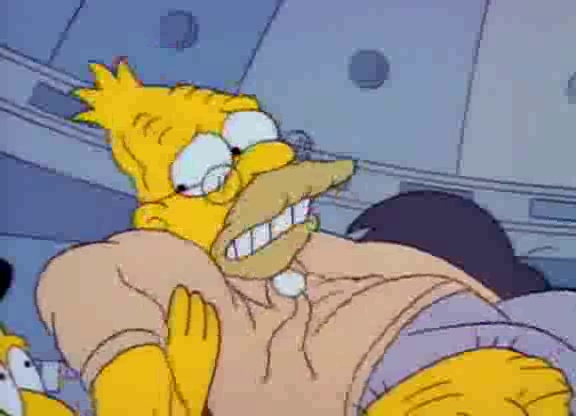

In [ ]:
from PIL import Image

image = Image.open('/content/simpsons_data/train/abraham_grampa_simpson/pic_0000.jpg')
image

In [ ]:
image_transformed = resnet_transforms(image)
print(image_transformed.shape)

torch.Size([3, 224, 224])


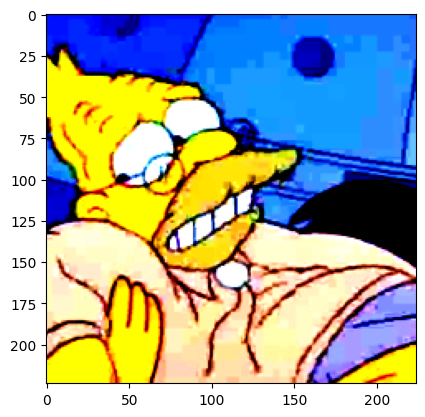

In [ ]:
plt.imshow(image_transformed.permute(1,2,0).data.cpu().numpy())

In [ ]:
model.eval()

with torch.no_grad():
    # image_transformed -> [image_transformed]
    model_output = model(image_transformed.reshape((1, 3, 224, 224)))

model_output

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
np.argmax(model_output.data.cpu().numpy())

917

**Попытка дообучить resnet**

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 42)

In [ ]:
# model.children() выдает список сабмодулей нейросети
# в нашем случае это блоки resnet
len(list(model.children()))

10

In [ ]:
# проходимся по блокам нейросети
for i, layer in enumerate(model.children()):

  # заморозим первые девять блоков
  if i < 9:
    # проходимся по всем весам (параметрам) блока
    for param in layer.parameters():
      # замораживаем паарметр
      param.requires_grad = False

In [ ]:
def create_model(model, num_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

model = create_model(models.resnet18(pretrained=True), 9, 42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def evaluate(model, dataloader, loss_fn):

    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        # получаем текущий батч
        X_batch, y_batch = batch
        num_elements += len(y_batch)

        # эта строка запрещает вычисление градиентов
        with torch.no_grad():
            # получаем ответы сети на картинки батча
            logits = model(X_batch.to(device))

            # вычисляем лосс на текущем батче
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            # вычисляем ответы сети как номера классов для каждой картинки
            y_pred = torch.argmax(logits, dim=1)

            # вычисляем количество правильных ответов сети в текущем батче
            num_correct += torch.sum(y_pred.cpu() == y_batch)

    # вычисляем итоговую долю правильных ответов
    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

def train(model, loss_fn, optimizer, n_epoch=3):

    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch+1)

        model.train(True)

        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(train_loader):
            # получаем текущий батч
            X_batch, y_batch = batch

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))
            running_losses.append(loss.item())

            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            # вычислим accuracy на текущем train батче
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)

            # Логирование результатов
            if (i+1) % 50 == 0:
                print("Средние train лосс и accuracy на последних 50 итерациях:",
                      np.mean(running_losses), np.mean(running_accuracies), end='\n')

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        print("Эпоха {}/{}: val лосс и accuracy:".format(epoch+1, n_epoch,),
                      val_loss, val_accuracy, end='\n')

    return model

In [ ]:
# снова объявим модель
#model = create_model(models.resnet18(pretrained=True), 9, 70)
model = ConvNet()
model = model.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, loss_fn, optimizer, n_epoch=3)

Epoch: 1
Средние train лосс и accuracy на последних 50 итерациях: 2.3222838258743286 0.3984375
Средние train лосс и accuracy на последних 50 итерациях: 1.954339143037796 0.48953125
Средние train лосс и accuracy на последних 50 итерациях: 1.738218304713567 0.54354167
Средние train лосс и accuracy на последних 50 итерациях: 1.584204221367836 0.5809375
Средние train лосс и accuracy на последних 50 итерациях: 1.4616642138957978 0.61275
Эпоха 1/3: val лосс и accuracy: 0.9201794826623165 0.75185096
Epoch: 2
Средние train лосс и accuracy на последних 50 итерациях: 0.7807354253530502 0.78875
Средние train лосс и accuracy на последних 50 итерациях: 0.7553309845924377 0.79734373
Средние train лосс и accuracy на последних 50 итерациях: 0.7270451225837071 0.8052083
Средние train лосс и accuracy на последних 50 итерациях: 0.7048598505556584 0.81257814
Средние train лосс и accuracy на последних 50 итерациях: 0.6964013677835464 0.8149375
Эпоха 2/3: val лосс и accuracy: 0.6930017028794144 0.8125149
Ep

In [ ]:
test_accuracy, _ = evaluate(model, test_loader, loss_fn)
print('Accuracy на тесте', test_accuracy)

Accuracy на тесте 0.042381432


## Получение ответов на тестовую выборку

Функция ниже позволит вам получить ответ вашей модели на тестовую выборку. Файл submission_hw05.npy нужно будет отправить на Я.Контест

In [ ]:
def get_predictions(model, dataloader):

    predicted_labels = []
    model.eval()
    predicted_labels = []

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, _ = batch

        with torch.no_grad():
            logits = model(X_batch.to(device))
            y_pred = torch.argmax(logits, dim=1)
            predicted_labels.append(y_pred)

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

# model — переменная, в которой находится ваша модель.
predicted_labels = get_predictions(model, test_loader)
idx_to_class = {y:x for x, y in class_to_idx.items()}
predicted_labels = [idx_to_class[x] for x in predicted_labels.data.cpu().numpy()]

np.save('submission_hw05.npy', predicted_labels, allow_pickle=True)
print('Ответ сохранен в файл `submission_hw05.npy`')

Ответ сохранен в файл `submission_hw05.npy`
